Reads the file `query_with_refinements.csv`

Genrate the images, save them to `image_query`

Overwrites the file `query.csv`

In [26]:
import pandas as pd
import sys
import os
import logging
from PIL import Image
from typing import List
import matplotlib.pyplot as plt
import openai
from openai.error import RateLimitError
import base64
import io
import dotenv
import time
import shutil
from typing import Optional
import logging
from huggingface_hub import HfApi, snapshot_download
import torch
from diffusers.utils import load_image
from transformers import AutoModelForCausalLM
from transformer import FluxTransformer2DConditionalModel
from pipeline import FluxConditionalPipeline

dataset = 'urban-reid-challenge-reduced'

################ Probably nothing has to be modified from now on ################
logging.root.setLevel(logging.INFO)
dotenv.load_dotenv()

os.environ['CUDA_VISIBLE_DEVICES']='0'
sys.path.append('assets/libs/diffusion-self-distillation')
assert os.path.exists('assets/libs/diffusion-self-distillation/')

In [23]:
class IdentityDiffuserDSD():
    def __init__(
        self,
        model_path: str,
        lora_path: str,
        guidance: float = 3.5,
        i_guidance: float = 1.0,
        t_guidance: float = 1.0,
        sequential_offload: bool = False,
        model_offload: bool = False,
        steps: int = 28,
    ):
        transformer = FluxTransformer2DConditionalModel.from_pretrained(
            model_path,
            torch_dtype=torch.bfloat16,
            ignore_mismatched_sizes=True,
        )
        pipe = FluxConditionalPipeline.from_pretrained(
            "black-forest-labs/FLUX.1-dev",
            transformer=transformer,
            torch_dtype=torch.bfloat16,
        )
        assert isinstance(pipe, FluxConditionalPipeline)
        pipe.load_lora_weights(lora_path)
        if model_offload:
            pipe.enable_model_cpu_offload()
        if sequential_offload:
            pipe.enable_sequential_cpu_offload()
        if not model_offload and not sequential_offload:
            pipe.to("cuda")

        self.guidance = guidance
        self.i_guidance = i_guidance
        self.t_guidance = t_guidance
        self.steps = steps
        self.pipe = pipe

    # Open the image
    def predict(
        self,
        image_path: str,
        output_path: str,
        text: str,
    ):
        image = Image.open(image_path).convert("RGB")

        print(f"Process image: {image_path}")

        # Process image and text
        result_image = self.process_image_and_text(
            self.pipe,
            image,
            text,
            self.guidance,
            self.i_guidance,
            self.t_guidance,
            self.steps
        )

        # Save the output
        result_image.save(output_path)
        print(f"Output saved to {output_path}")

    def process_image_and_text(
        self,
        pipe,
        image,
        text,
        guidance,
        i_guidance,
        t_guidance,
        steps,
    ):
        """Process the given image and text using the global pipeline."""
        # center-crop image
        w, h = image.size
        min_size = min(w, h)
        image = image.crop(
            (
                (w - min_size) // 2,
                (h - min_size) // 2,
                (w + min_size) // 2,
                (h + min_size) // 2,
            )
        )
        image = image.resize((512, 512))

        control_image = load_image(image)
        result = pipe(
            prompt=text.strip().replace("\n", "").replace("\r", ""),
            negative_prompt="",
            num_inference_steps=steps,
            height=512,
            width=1024,
            guidance_scale=guidance,
            image=control_image,
            guidance_scale_real_i=i_guidance,
            guidance_scale_real_t=t_guidance,
        ).images[0]

        return result

Some weights of the model checkpoint at assets/models/dsd_pretrained/transformer were not used when initializing FluxTransformer2DConditionalModel: 
 ['transformer_blocks.0.attn.to_add_out.lora_B.default.weight, single_transformer_blocks.21.attn.to_k.lora_B.default.weight, single_transformer_blocks.32.attn.to_k.lora_B.default.weight, transformer_blocks.4.attn.add_q_proj.lora_A.default.weight, single_transformer_blocks.17.attn.to_v.lora_A.default.weight, single_transformer_blocks.36.attn.to_k.lora_A.default.weight, transformer_blocks.9.attn.add_v_proj.lora_A.default.weight, transformer_blocks.4.attn.to_v.lora_B.default.weight, transformer_blocks.5.attn.to_v.lora_A.default.weight, transformer_blocks.0.attn.add_q_proj.lora_A.default.weight, single_transformer_blocks.8.attn.to_k.lora_B.default.weight, transformer_blocks.3.attn.to_k.lora_A.default.weight, transformer_blocks.5.attn.to_add_out.lora_A.default.weight, single_transformer_blocks.13.attn.to_q.lora_A.default.weight, single_transfor

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to T5EncoderModel found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any T5EncoderModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


Token indices sequence length is longer than the specified maximum sequence length for this model (93 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['surrounding the crosswalk has visible cracks and uneven surfaces, enhancing its worn appearance.']


Generating 9 images
Process image: assets/datasets/urban-reid-challenge-reduced/image_query/000001.jpg


  0%|          | 0/28 [00:00<?, ?it/s]

Output saved to assets/datasets/urban-reid-challenge-reduced/image_query/000001_refinement_A.jpg


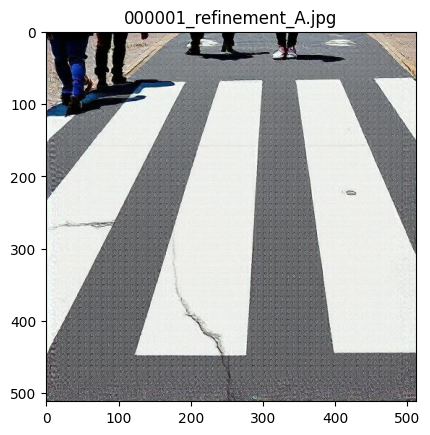

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['dent about halfway up, which could aid in locating the crosswalk in relation to it.']


Process image: assets/datasets/urban-reid-challenge-reduced/image_query/000002.jpg


  0%|          | 0/28 [00:00<?, ?it/s]

Output saved to assets/datasets/urban-reid-challenge-reduced/image_query/000002_refinement_A.jpg


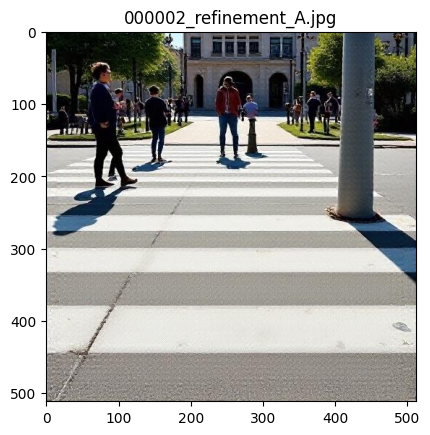

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['surrounding pavement. additionally, a shadow from a nearby tree partially obscures the left side of the crosswalk, creating a distinct visual effect.']


Process image: assets/datasets/urban-reid-challenge-reduced/image_query/000003.jpg


  0%|          | 0/28 [00:00<?, ?it/s]

Output saved to assets/datasets/urban-reid-challenge-reduced/image_query/000003_refinement_A.jpg


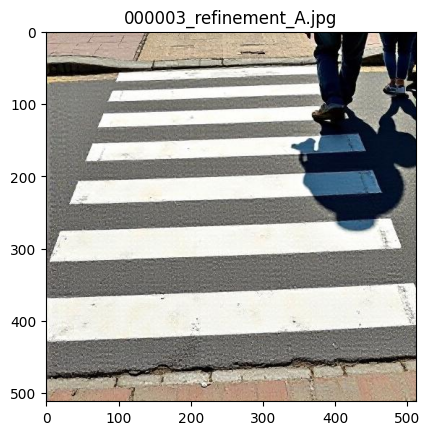

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['crosswalk has visible cracks and uneven surfaces, enhancing its worn appearance.']


Process image: assets/datasets/urban-reid-challenge-reduced/image_query/000001.jpg


  0%|          | 0/28 [00:00<?, ?it/s]

Output saved to assets/datasets/urban-reid-challenge-reduced/image_query/000001_refinement_B.jpg


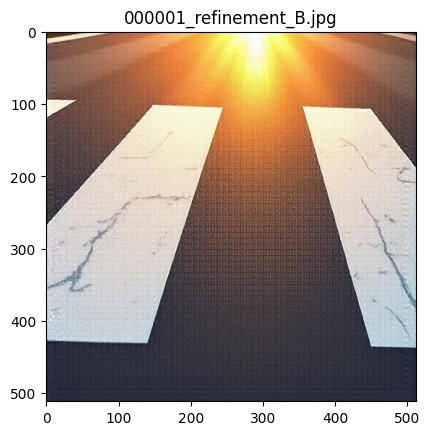

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['halfway up, which could aid in locating the crosswalk in relation to it.']


Process image: assets/datasets/urban-reid-challenge-reduced/image_query/000002.jpg


  0%|          | 0/28 [00:00<?, ?it/s]

Output saved to assets/datasets/urban-reid-challenge-reduced/image_query/000002_refinement_B.jpg


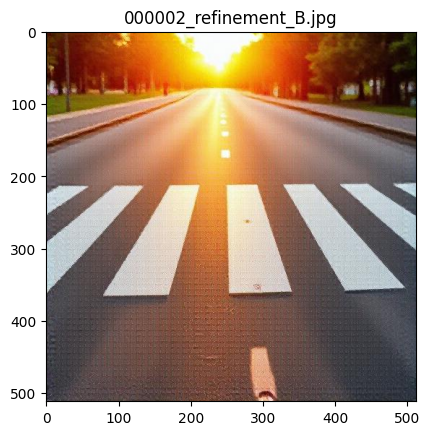

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['. additionally, a shadow from a nearby tree partially obscures the left side of the crosswalk, creating a distinct visual effect.']


Process image: assets/datasets/urban-reid-challenge-reduced/image_query/000003.jpg


  0%|          | 0/28 [00:00<?, ?it/s]

Output saved to assets/datasets/urban-reid-challenge-reduced/image_query/000003_refinement_B.jpg


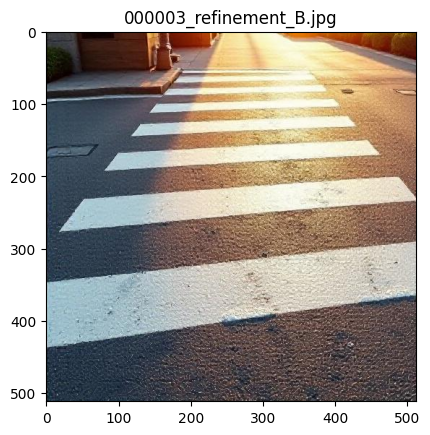

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['crosswalk has visible cracks and uneven surfaces, enhancing its worn appearance.']


Process image: assets/datasets/urban-reid-challenge-reduced/image_query/000001.jpg


  0%|          | 0/28 [00:00<?, ?it/s]

Output saved to assets/datasets/urban-reid-challenge-reduced/image_query/000001_refinement_C.jpg


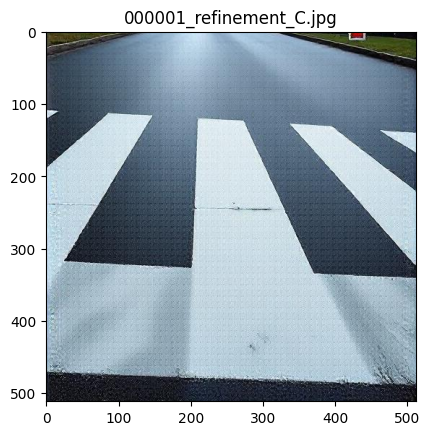

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['halfway up, which could aid in locating the crosswalk in relation to it.']


Process image: assets/datasets/urban-reid-challenge-reduced/image_query/000002.jpg


  0%|          | 0/28 [00:00<?, ?it/s]

Output saved to assets/datasets/urban-reid-challenge-reduced/image_query/000002_refinement_C.jpg


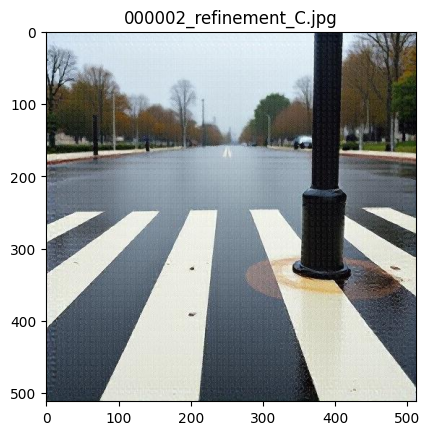

The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['. additionally, a shadow from a nearby tree partially obscures the left side of the crosswalk, creating a distinct visual effect.']


Process image: assets/datasets/urban-reid-challenge-reduced/image_query/000003.jpg


  0%|          | 0/28 [00:00<?, ?it/s]

Output saved to assets/datasets/urban-reid-challenge-reduced/image_query/000003_refinement_C.jpg


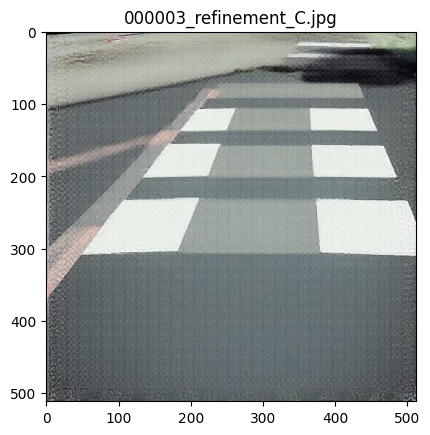

In [24]:
df = pd.read_csv(f'assets/datasets/{dataset}/query_with_refinements.csv')
df = df[df['imageName'].str.contains('_refinement_')]

model = IdentityDiffuserDSD(
    model_path="assets/models/dsd_pretrained/transformer",
    lora_path="assets/models/dsd_pretrained/pytorch_lora_weights.safetensors",
    guidance=3.5,
    i_guidance=1.0,
    t_guidance=1.0,
)

print(f'Generating {df.shape[0]} images')
for index, row in df.iterrows():
    output_path = os.path.join(f'assets/datasets/{dataset}/image_query', row['imageName'])

    model.predict(
        image_path=output_path.replace('_refinement', '').replace('_A.', '.').replace('_B.', '.').replace('_C.', '.'),
        output_path=output_path,
        text=row['description'],
    )

    plt.imshow(plt.imread(output_path))
    plt.title(row['imageName'])
    plt.show()


#--text 
#model_path: Path to the 'transformer' folder
#lora_path: Path to the 'pytorch_lora_weights.safetensors' file
#--guidance 3.5 \                                            # Guidance scale
#--i_guidance 1.0 \                                          # True image guidance scale, set to >1.0 if you want to enhance the image conditioning
#--t_guidance 1.0 \                                          # True text guidance scale, set to >1.0 if you want to enhance the text conditioning
#--model_offload \                                           # Enable basic model offloading to CPU to reduce GPU memory usage (recommended, requires ~23.7GB VRAM)
#--sequential_offload \                                      # Enable more aggressive sequential offloading (saves more memory but much slower, requires < 1GB VRAM)
# --disable_gemini_prompt \                                  # Disable Gemini prompt enhancement, not recommended unless you have a very detailed prompt


# TODO: warning "Some weights of the model checkpoint were not used when initializing FluxTransformer2DConditionalModel"